Возьмем данные по стоимости криптовалюты Ethereum за все время (с 2016 года)

https://ru.investing.com/crypto/ethereum/historical-data

(см data.csv)

Импортируем данные в pandas

In [ ]:
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df = pd.read_csv('data.csv', sep=",")
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index(['Date'])
df.sort_index(inplace=True)
df['Price'] = pd.to_numeric(df['Price'].str.replace(",", ""))

print(df.shape)
df.info()
df.describe()
print(df.head())

(397, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 2016-03-13 to 2023-10-15
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     397 non-null    float64
 1   Open      397 non-null    object 
 2   High      397 non-null    object 
 3   Low       397 non-null    object 
 4   Vol.      397 non-null    object 
 5   Change %  397 non-null    object 
dtypes: float64(1), object(5)
memory usage: 21.7+ KB
            Price   Open   High    Low     Vol. Change %
Date                                                    
2016-03-13  10.31  12.92  15.07   8.34  466.81K  -20.20%
2016-03-20  11.00  10.55  12.47   9.56  279.69K    6.69%
2016-03-27  11.61  10.93  12.30  10.17  284.70K    5.55%
2016-04-03   9.15  11.61  11.76   9.00  292.70K  -21.19%
2016-04-10   8.54   9.15   9.43   6.86  534.18K   -6.67%


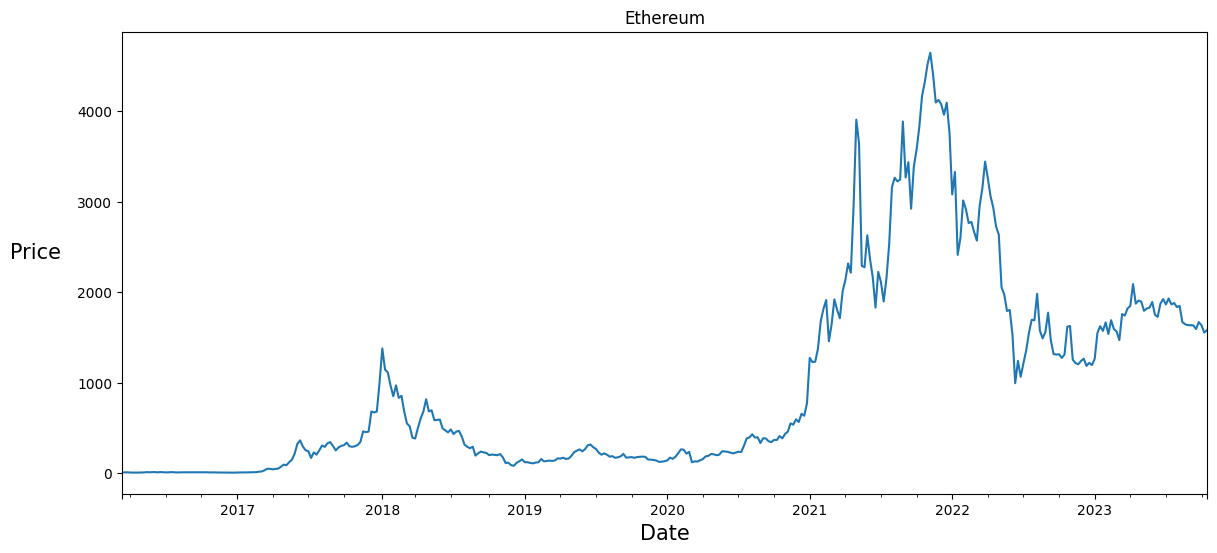

In [ ]:
plt.figure(figsize=(14, 6))
plt.title('Ethereum')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
df['Price'].plot();

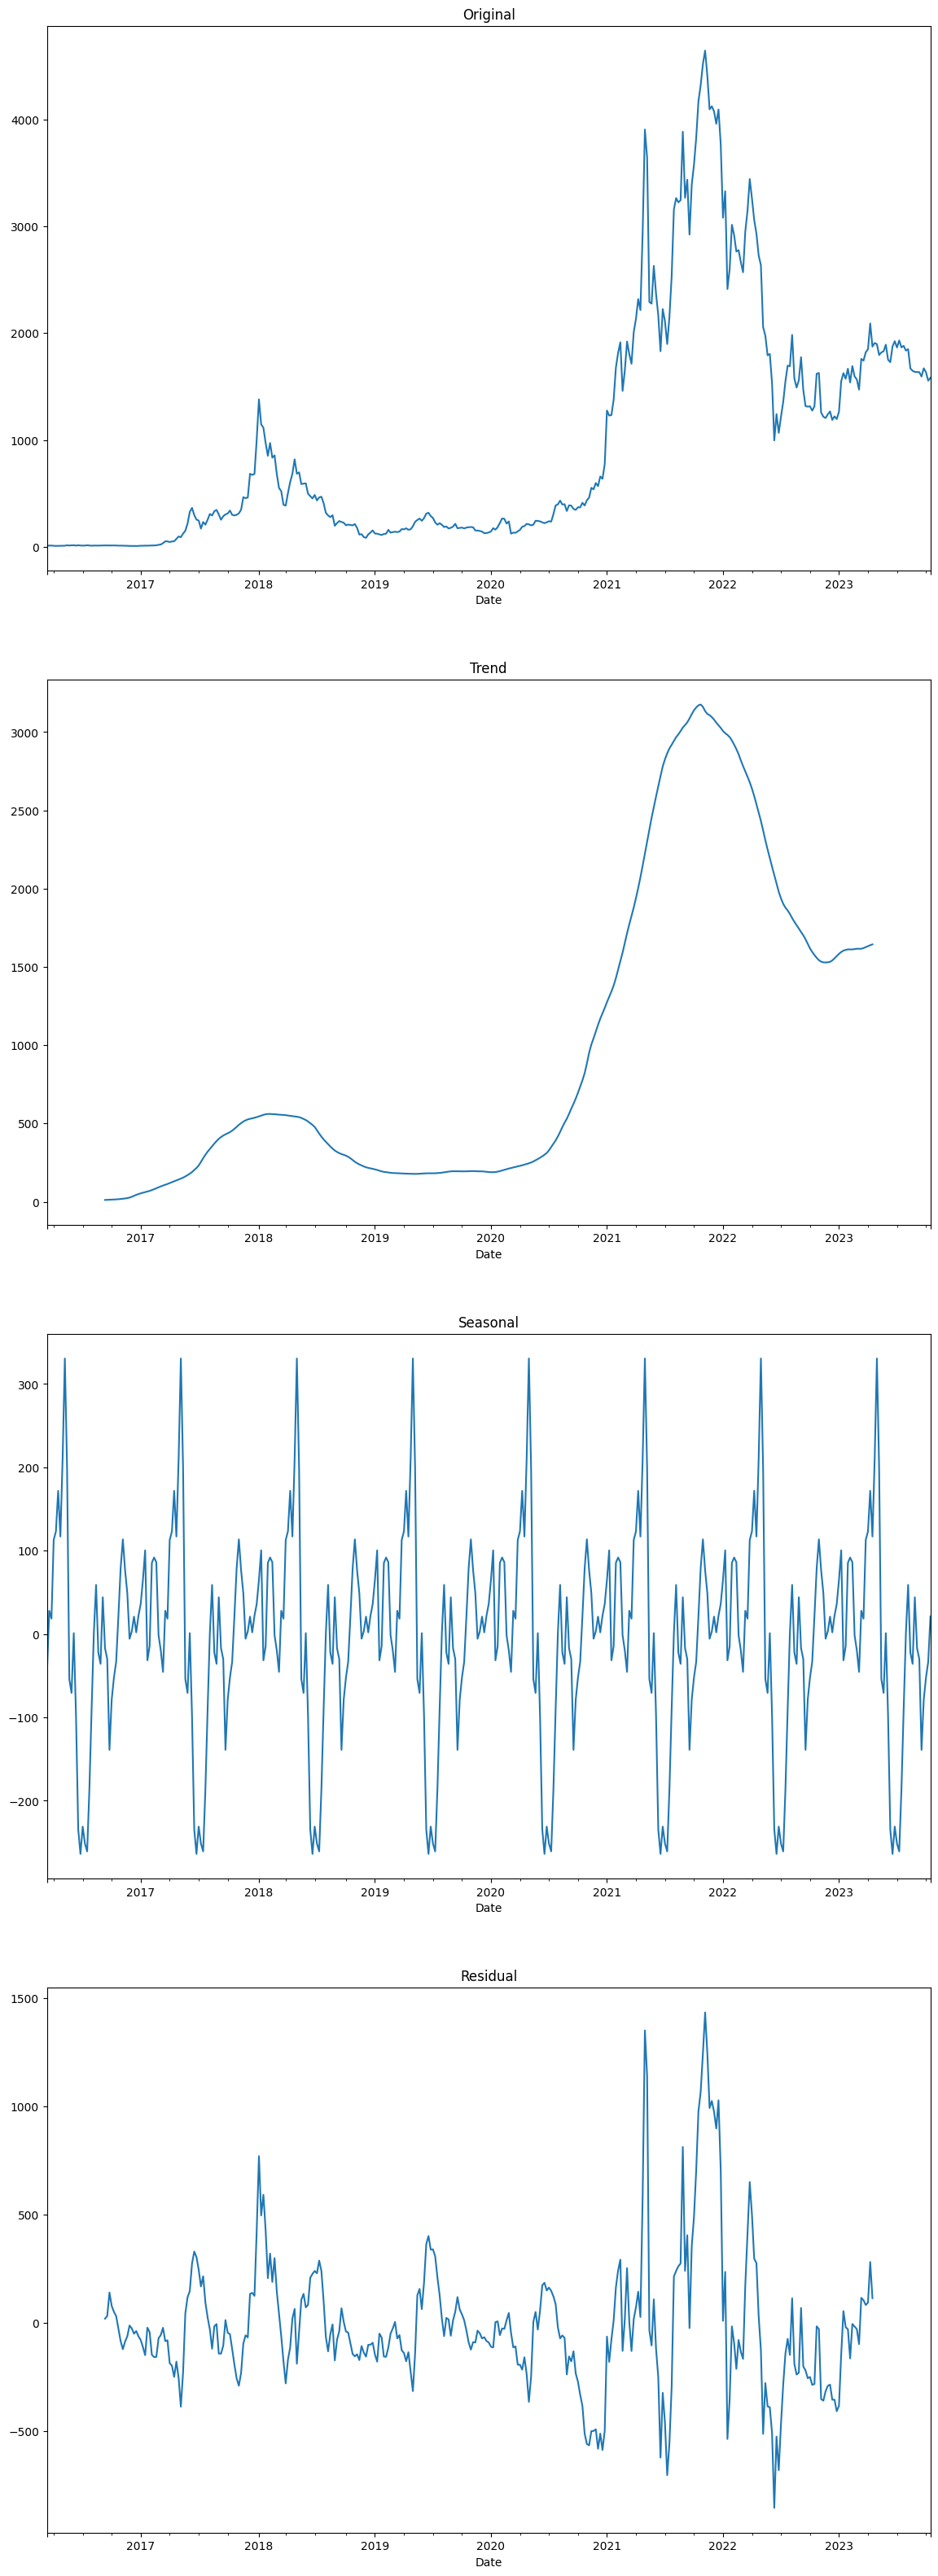

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df['Price'])

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

Прологорифмируем:

<Axes: xlabel='Date'>

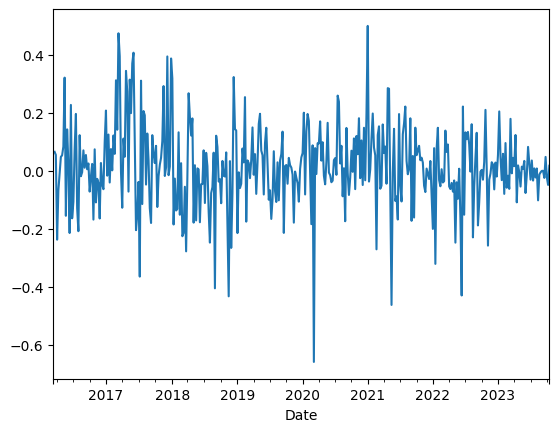

In [ ]:
df['diff1'] = np.log(df['Price'])
df['diff1'] = df['diff1'] - df['diff1'].shift(1)
df['diff1'].plot()

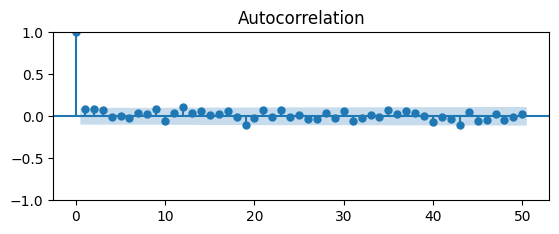

In [ ]:
ax = plt.subplot(212)
plot_acf(df['diff1'][1:], lags=50, ax=ax);

Значит, ряд становится стационарным при дифференцировании и мы можем использовать модель ARIMA

In [ ]:
print(df.shape)


(397, 8)


Реализуем ARIMA самостоятельно.

ARIMA(p, d, q) = AR(p) I(d) MA(q), где

I - дифференцирование

AR - авторегрессия

MA - скользящее среднее


Построим AR и сравним с библиотечной реализацией

In [ ]:
import scipy
import numpy as np

def gen_ar_fun(p, data):
  def fun(arg):
    return sum([(data[t - 1] - sum([arg[k - 1] * data[t - k - 1] for k in range(1, p + 1)]))**2 for t in range(p + 1, len(data) + 1)])
  return fun

def fit_ar(data, p):
  res = scipy.optimize.minimize(gen_ar_fun(p, data), [0 for i in range(p)], method="bfgs",options={"eps": 1e-7})
  print(res)
  return res.x

def predict_ar(data, arg, start=300):
  def get(ind):
    if ind < start:
      return data[ind]
    else:
      return res_val[ind]

  res_index = []
  res_val = []
  for ind, (index, row) in enumerate(data.items()):
    res_index.append(index)
    if ind < len(arg):
      res_val.append(data[ind])
    else:
      if ind >= start:
        res_val.append(sum([arg[k - 1] * res_val[ind - k] for k in range(1, len(arg) + 1)]))
      else:
        res_val.append(data[ind])
        #res_val.append(sum([data[i] * arg[abs(i - ind + 1)] for i in range(ind  - 1, ind - p - 1, -1)]))
  return pd.Series(res_val, index=res_index)



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Date
2016-03-13         NaN
2016-03-20    0.064781
2016-03-27    0.053972
2016-04-03   -0.238113
2016-04-10   -0.068993
                ...   
2023-09-17   -0.000190
2023-09-24    0.000083
2023-10-01   -0.000132
2023-10-08    0.000067
2023-10-15    0.000098
Name: Model, Length: 397, dtype: float64


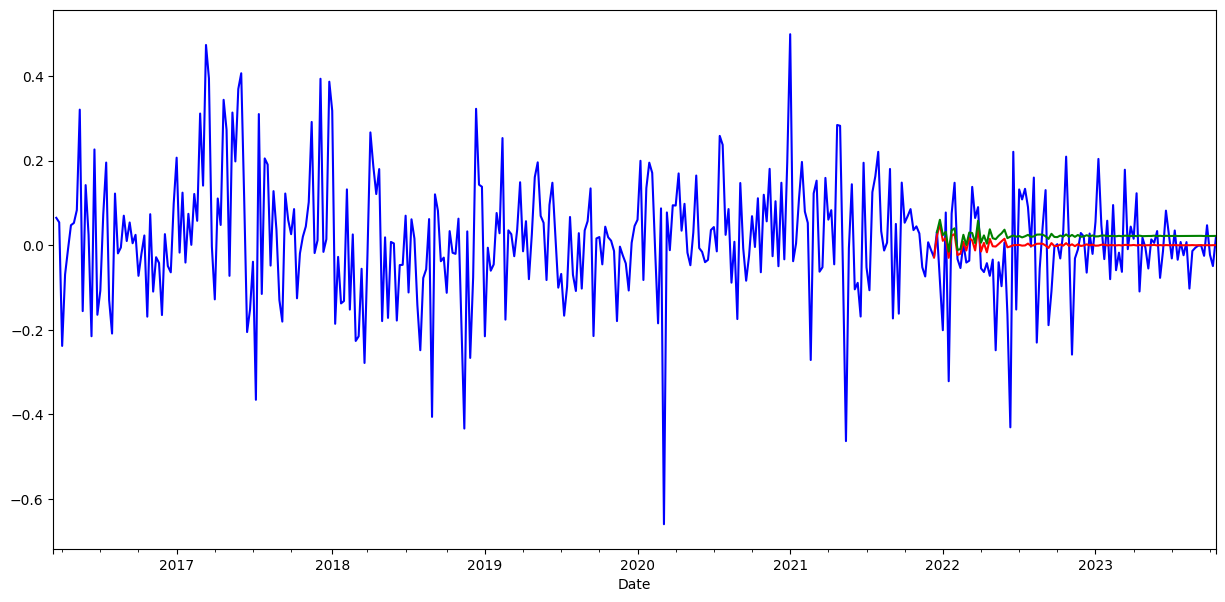

In [ ]:


p = 30
res = fit_ar(df['diff1'][1:300], p)

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot()
df['diff1'].plot(ax=ax, color="blue")
df['Model'] = predict_ar(df['diff1'][1:], res, start=300)
df['Model'][300:].plot(ax=ax, color="red")
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(df['diff1'][1:300], lags=p).fit()
df['Model2'] = ar_model.predict(start=300, end=400)
df['Model2'].plot(ax=ax, color="green")
print(df['Model'])



Построим MA и сравним с библиотечной реализацией

In [ ]:
def gen_ma_fun(q, data):
  e = data.mean()
  def fun(arg):
    res = 0
    res_val = [sum(data) / len(data)]
    for t in range(1, len(data)):
      val = e + sum([arg[abs(t - 1 - k) ] * abs(data[k] - res_val[k]) for k in range(t - 1, max(0, t - q - 1), -1)])
      res += (data[t] - val)**2
      res_val.append(val)
    return res
  return fun

def get_noise(data, k):
  return np.random.normal(data.mean(), data.var())

def predict_ma(data, arg, start=300):
  e = data[:start].mean()
  res_index = []
  res_val = [sum(data[:start]) / len(data[:start])]
  noise = np.random.normal(data[:start].mean(), data[:start].var(), len(data))
  for ind, (index, row) in enumerate(data.items()):
    res_index.append(index)
    if ind < 1:
      pass
    else:
      if ind >= start:
        val = e + sum([arg[abs(ind - 1 - k) ] * noise[k] for k in range(ind - 1, max(0, ind - len(arg) - 1), -1)])
      else:
        val = data[ind]
      res_val.append(val)
  return pd.Series(res_val, index=res_index)

def fit_ma(data, q):
  res = scipy.optimize.minimize(gen_ma_fun(q, data), [0 for i in range(q)], method="cg",options={"eps": 1e-7})
  print(res)
  return res.x


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4.230516709474867
       x: [ 1.395e-01  1.256e-01  1.601e-01 -1.194e-01 -3.131e-02
            3.831e-02  1.128e-01  3.167e-02  6.155e-02 -1.108e-02]
     nit: 12
     jac: [ 5.373e-06 -1.901e-06 -2.691e-06 -2.247e-06  1.297e-06
           -2.309e-06  3.730e-07  8.438e-07  5.027e-06  2.469e-06]
    nfev: 286
    njev: 26


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

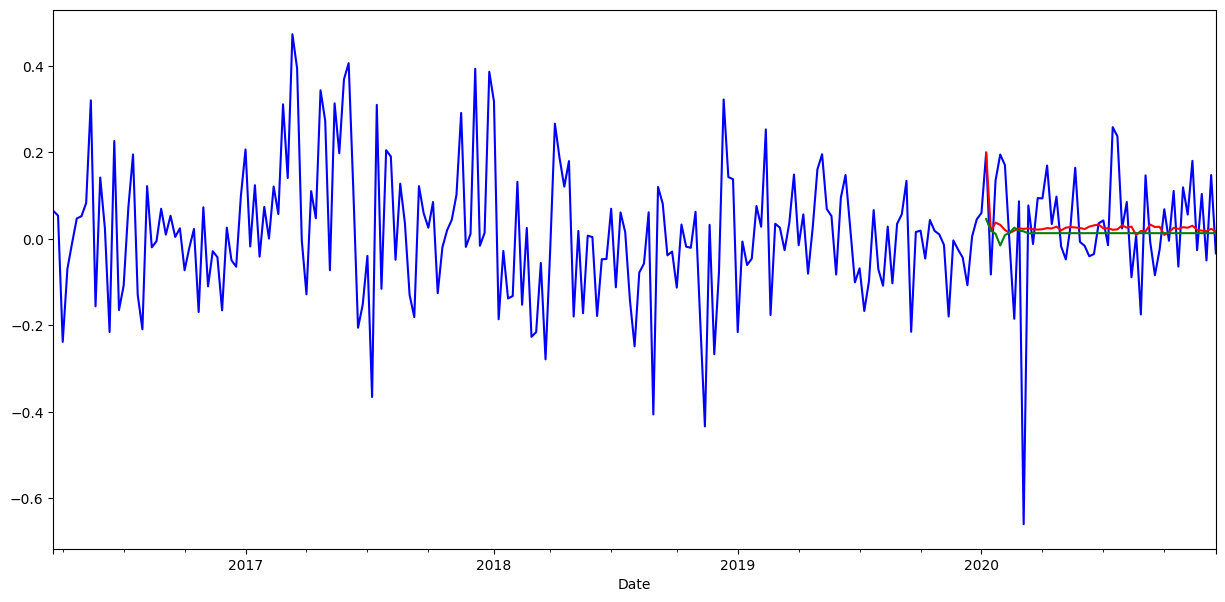

In [ ]:
q = 10
res = fit_ma(df['diff1'][1:200], q)

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot()
df['diff1'][1:250].plot(ax=ax, color="blue")
df['ModelMA'] = predict_ma(df['diff1'][1:250], res, start=200)
df['ModelMA'][200:250].plot(ax=ax, color="red")
ma_model = ARIMA(endog=df['diff1'][1:200], order=(0, 0, q)).fit()

df['Model2MA'] = ma_model.predict(start=0, end=250)
df['Model2MA'][200:250].plot(ax=ax, color="green")


Заведем дифференцирование, проверим корректность

Original
Date
2016-03-13    10.31
2016-03-20    11.00
2016-03-27    11.61
2016-04-03     9.15
2016-04-10     8.54
Name: Price, dtype: float64
Date
2016-03-13     NaN
2016-03-20     NaN
2016-03-27     NaN
2016-04-03   -2.99
2016-04-10    4.92
Name: Price, dtype: float64
Integrated
Date
2016-03-13    10.31
2016-03-20    11.00
2016-03-27    11.61
2016-04-03     9.15
2016-04-10     8.54
Name: Price, dtype: float64


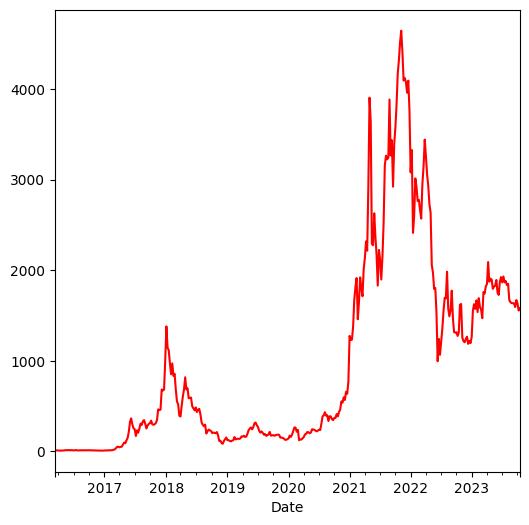

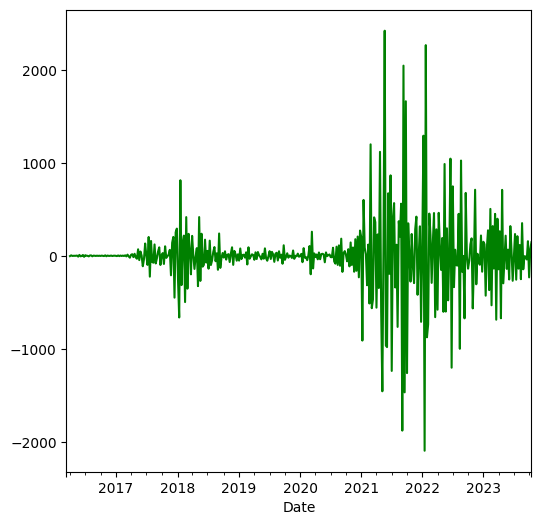

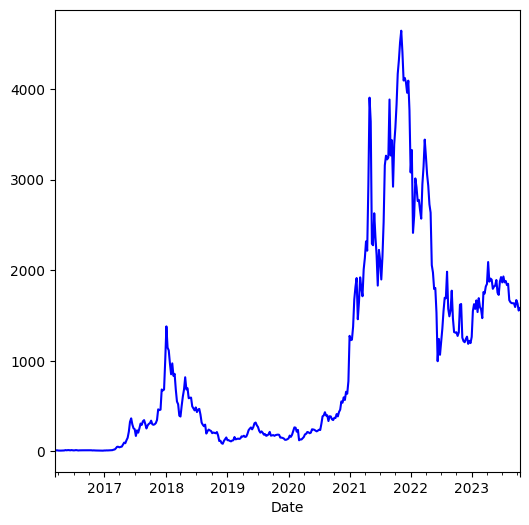

In [ ]:
def integral(data, start, n):
  data[n] = start[0]
  for i in range(n + 1, len(data)):
    data[i] = data[i] + data[i - 1]
  return data

def diff_series(data, n):
  revert = []
  for i in range(n):
    revert.append(data.copy())
    data = data - data.shift(1)
  return revert, data

def revert_series(revert, data):
  last = data[:]
  for i in range(len(revert)):
    last = integral(last, revert[len(revert) - i - 1], len(revert) - i - 1)
  return last

print('Original')
fig, ax = plt.subplots(figsize=(6,6))
df['Price'].plot(color="red", ax=ax)
print(df['Price'].head())
revert, data = diff_series(df['Price'], 3)
print(data.head())
fig, ax = plt.subplots(figsize=(6,6))
data.plot(color="green", ax=ax)
print('Integrated')
fig, ax = plt.subplots(figsize=(6,6))
original = revert_series([(revert[i][i], revert[i].index.values[i]) for i in range(len(revert))], data)
original.plot(color="blue", ax=ax)
print(original.head())

Соберем полноценную ARIMA из полученных реализаций:

In [ ]:
class Arima:

  def __init__(self, p, d, q):
    self.p = p
    self.d = d
    self.q = q

  def fit(self, data, limit):
    revert, series = diff_series(data.copy(), self.d)
    self.revert = revert
    self.data = series
    self.limit = limit

    self.ar_args = fit_ar(self.data[self.d:limit], self.p)
    self.ma_args = fit_ma(self.data[self.d:limit], self.q)

  def predict(self, limit):
    ar_predict = self.data[:self.d].append(predict_ar(self.data[self.d:limit], self.ar_args, start=self.limit))
    ma_predict = self.data[:self.d].append(predict_ma(self.data[self.d:limit], self.ma_args, start=self.limit))
    res_data = ar_predict + (ma_predict - self.data[self.d:self.limit].mean())
    result = revert_series([(self.revert[i][i], self.revert[i].index.values[i]) for i in range(len(self.revert))], res_data)
    return result




  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.237533193834063
        x: [-1.802e+00 -2.501e+00 ... -7.261e-02 -1.057e-02]
      nit: 80
      jac: [-2.576e-07  4.796e-07 ...  1.075e-06 -3.375e-07]
 hess_inv: [[ 8.860e-02  1.570e-01 ...  4.354e-03  3.011e-03]
            [ 1.570e-01  3.682e-01 ...  1.085e-02  5.530e-03]
            ...
            [ 4.354e-03  1.085e-02 ...  3.749e-01  1.606e-01]
            [ 3.011e-03  5.530e-03 ...  1.606e-01  9.006e-02]]
     nfev: 4590
     njev: 90
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 23.192335118475285
       x: [-1.109e-01  1.383e-01 ...  7.769e-02  8.811e-02]
     nit: 130
     jac: [-4.195e+00  1.352e+00 ... -1.620e+01 -2.414e+01]
    nfev: 17348
    njev: 340


<ipython-input-339-b0d4a834814d>:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ar_predict = self.data[:self.d].append(predict_ar(self.data[self.d:limit], self.ar_args, start=self.limit))
<ipython-input-339-b0d4a834814d>:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ma_predict = self.data[:self.d].append(predict_ma(self.data[self.d:limit], self.ma_args, start=self.limit))
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_

'\np = 30\nd = 1\nq = 5\n'

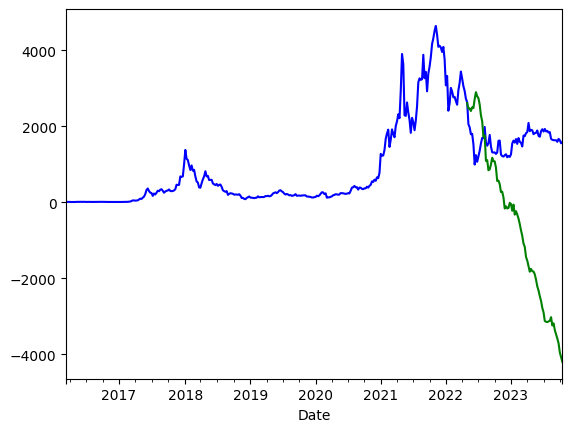

In [ ]:
p = 50
d = 3
q = 50
df['logprice'] = np.log(df['Price'])
df['Price'].plot(color="blue")
arima = Arima(p, d, q)
arima.fit(df['logprice'], 320)
df['Arima'] = np.exp(arima.predict(400))
df['Arima'][320:].plot(color="red")

lib_arima =  ARIMA(df['Price'][:320], order=(p, d, q)).fit()
df['ArimaLib'] = lib_arima.predict(start=0, end=400)[320:]
df['ArimaLib'].plot(color="green")
"""
p = 30
d = 1
q = 5
"""

In [ ]:
import sklearn.metrics

print('MAPE:')
print('My')
print(sklearn.metrics.mean_absolute_percentage_error(df['Price'][320:], df['Arima'][320:]))
print('Lib')
print(sklearn.metrics.mean_absolute_percentage_error(df['Price'][320:], df['ArimaLib'][320:]))

print('precision')
print(sklearn.metrics.precision_score(np.round(df['Price'][320:]), np.round(df['Arima'][320:]), average="weighted"))

print('recall')
print(sklearn.metrics.recall_score(np.round(df['Price'][320:]), np.round(df['Arima'][320:]), average="weighted"))



MAPE:
My
0.5657725576173777
Lib
0.6615524176129348
precision
0.0
recall
0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
